## Geração de imagens com GANs

### GANs?
As **Generative Adversarial Networks (GANs)** são uma arquitetura de aprendizado de máquina onde dois modelos neurais competem em um jogo de soma zero:

- **Gerador (G)**: Cria dados sintéticos a partir de ruído aleatório
- **Discriminador (D)**: Distingue entre dados reais e sintéticos

### A Analogia do Falsificador
```
Falsificador (Gerador) ←→ Detetive (Discriminador)
      ↓                           ↓
Criar notas falsas         Detectar falsificações
      ↓                           ↓
Melhorar técnica          Aprimorar detecção
      ↓                           ↓
Até que seja impossível distinguir real de falso
```

### DCGANs: Evolução das GANs
As **Deep Convolutional GANs** introduzem:
- Camadas convolucionais em vez de totalmente conectadas
- Melhor estabilidade de treinamento
- Maior qualidade na geração de imagens
- Arquitetura específica para dados visuais

- Código adaptado da documentação: https://www.tensorflow.org/beta/tutorials/generative/dcgan




## Etapa 1: Importação das bibliotecas

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import tensorflow as tf


## Etapa 2: Importação e tratamento da base de dados

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [7]:
train_images.shape

(60000, 28, 28, 1)

In [8]:
# Normalização entre -1 e 1
train_images = (train_images - 127.5) / 127.5

In [9]:
buffer_size = 60000
batch_size = 256

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

# Etapa 3: Visualização dos dados

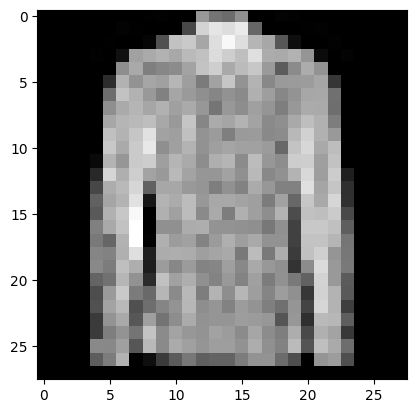

In [12]:
plt.imshow(train_images[112].reshape((28,28)) , cmap = 'gray')

# Etapa 4: Construção do gerador

In [13]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # 12544
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))

  # 7x7x128
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # 14x14x64
  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # 28x28x1
  model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))

  model.summary()

  return model

In [14]:
noise = tf.random.normal([1, 100])

In [16]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.26082844,  0.3239237 , -0.00389298,  1.2789181 , -0.93593866,
        -1.2086728 , -0.19833893,  0.46619076,  0.5176041 , -0.89939487,
         0.45321426, -0.58969885, -0.5333876 ,  0.56728894,  0.7904823 ,
        -0.4123103 ,  1.3320156 , -0.7026148 , -0.0439032 , -0.8364633 ,
         0.34193456, -0.06934857,  0.18387958,  1.1276076 ,  1.2859427 ,
        -2.1763322 , -0.741732  ,  1.6193664 ,  0.82906955, -2.4415343 ,
         1.1404967 , -0.35715076,  1.1928712 ,  0.55151916, -0.13484815,
         0.3974159 ,  1.4338553 ,  1.2565008 ,  0.09488918,  0.23928167,
         1.4855763 ,  2.2250066 , -0.5250649 ,  0.7269235 , -1.1448673 ,
         1.739459  ,  0.853855  , -0.43210724, -1.2699275 , -1.2140516 ,
         0.40532684,  0.4812019 ,  0.8343356 , -1.3034872 ,  0.25049675,
         0.5695438 , -1.6807413 ,  0.976466  , -1.0949574 , -0.72011566,
        -1.664911  , -1.0822842 ,  1.4550521 ,  0.12902874,  0.34306565,
 

In [17]:
generator = make_generator_model()

/Users/arnaldoalvesvianajunior/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [18]:
generated_image = generator(noise, training = False)

In [19]:
generated_image.shape

TensorShape([1, 28, 28, 1])

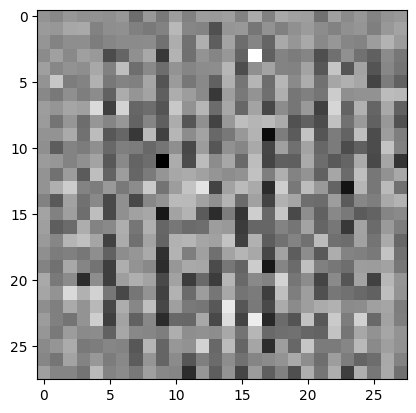

In [20]:
plt.imshow(generated_image[0,:,:,0], cmap='gray')

# Etapa 5: Construção do discriminador

In [21]:
def make_discrimator_model():
  model = tf.keras.Sequential()
  # 14x14x64
  model.add(layers.Conv2D(64, (5,5), strides = (2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # 7x7x128
  model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # 6272
  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  model.summary()

  return model

In [22]:
discriminator = make_discrimator_model()

/Users/arnaldoalvesvianajunior/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
decision = discriminator(generated_image, training = False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00241462]], dtype=float32)>

# Etapa 6: Loss function para as duas redes

In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [26]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # 0.00001
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # 0.00001

In [28]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Etapa 7: Treinamento do modelo

In [29]:
epochs = 100
noise_dim = 100
num_examples_to_generate = 16

In [30]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [31]:
batch_size

256

In [32]:
@tf.function # Compilar o modelo para acelerar o treinamento
def train_steps(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Chamar o gerador e passar os números aleatórios
    generated_images = generator(noise, training = True)

    # Passar para o discriminador as imagens reais e falsas para fazer a classificação
    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    # Calcular a loss para o gerador e discriminador
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  # Calcular o gradiente das losses para atualizar os pesos
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # Aplicar os otimizadores e atualizar os pesos
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [33]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_steps(image_batch)

    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch + 1, seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  display.clear_output(wait = True)
  generate_and_save_images(generator, epoch + 1, seed)

In [34]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training = False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

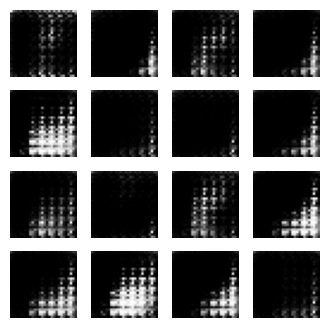

Time for epoch 1 is 334.7774250507355 sec


KeyboardInterrupt: 

In [35]:
train(train_dataset, epochs)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

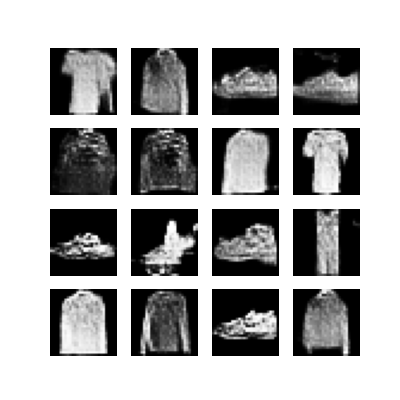

In [ ]:
display_image(100)